In [9]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
#import json

In [10]:
# Yahoo Finance Data Download:

#from pandas_datareader import data as pdr
#import yfinance as yf

#yf.pdr_override()
#download_date = datetime.now().strftime("%Y-%m-%d")
#print("Download date = "+download_date)

#bitcoin_data = pdr.get_data_yahoo("BTC-USD", start="2007-01-10", end="2024-02-28")
#bitcoin_data.to_csv('data/yahoo_bitcoin_data_'+download_date+'.csv', index=True)

#ex_rates_data = pdr.get_data_yahoo("USDMXN=X", start="2007-01-10", end="2024-02-28")
#ex_rates_data.to_csv('data/yahoo_ex_rates_data_'+download_date+'.csv', index=True)

# 1. Read Data:

In [20]:
df_tp = pd.read_csv('tortilla_prices.csv')
print(df_tp.shape)
print(df_tp.head())
print(df_tp.dtypes)

df_ex_rates = pd.read_csv('yahoo_ex_rates_data_2024-03-19.csv')
print(df_ex_rates.shape)
print(df_ex_rates.head())
print(df_ex_rates.dtypes)

df_bitcoin = pd.read_csv('yahoo_bitcoin_data_2024-03-19.csv')
print(df_bitcoin.shape)
print(df_bitcoin.head())
print(df_bitcoin.dtypes)

(278886, 7)
                 State            City  Year  Month  Day         Store type  \
0       Aguascalientes  Aguascalientes  2007      1   10  Mom and Pop Store   
1      Baja California        Mexicali  2007      1   10  Mom and Pop Store   
2      Baja California         Tijuana  2007      1   10  Mom and Pop Store   
3  Baja California Sur          La Paz  2007      1   10  Mom and Pop Store   
4             Campeche        Campeche  2007      1   10  Mom and Pop Store   

   Price per kilogram  
0                 9.9  
1                 NaN  
2                10.0  
3                10.0  
4                10.0  
State                  object
City                   object
Year                    int64
Month                   int64
Day                     int64
Store type             object
Price per kilogram    float64
dtype: object
(4464, 7)
         Date     Open     High     Low    Close  Adj Close  Volume
0  2007-01-10  10.9972  11.0625  10.939  10.9685    10.9685       0

In [21]:
df_tp.tail()

,State,City,Year,Month,Day,Store type,Price per kilogram
278881,Veracruz,Coatzacoalcos,2024,3,1,Big Retail Store,12.50
278882,Veracruz,Veracruz,2024,3,1,Big Retail Store,13.57
278883,Veracruz,Xalapa,2024,3,1,Big Retail Store,13.97
278884,Yucatán,Mérida,2024,3,1,Big Retail Store,13.20
278885,Zacatecas,Zacatecas,2024,3,1,Big Retail Store,13.33


# 2. Transform Year, Month and Day to datetime Object:

In [22]:
df_tp["date"] = df_tp.apply(lambda x: pd.to_datetime(str(x["Year"])+"-"+str(x["Month"])+"-"+str(x["Day"]), format='%Y-%m-%d'), axis=1)
df_tp = df_tp.drop(columns=["Year", "Month", "Day"])
df_tp.dtypes

State                         object
City                          object
Store type                    object
Price per kilogram           float64
date                  datetime64[ns]
dtype: object

In [23]:
df_bitcoin["date"] = df_bitcoin["Date"].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df_bitcoin = df_bitcoin.drop(columns=["Date"])
df_bitcoin.dtypes

Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
date         datetime64[ns]
dtype: object

In [24]:
df_ex_rates["date"] = df_ex_rates["Date"].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df_ex_rates = df_ex_rates.drop(columns=["Date"])
df_ex_rates.dtypes

Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
date         datetime64[ns]
dtype: object

# 3. Cut Time Series to Same Length:

In [25]:
print("Start Date:")
start_date = np.max([df_tp["date"].min(), df_bitcoin["date"].min(), df_ex_rates["date"].min()])
print(start_date)
print("End Date:")
end_date = np.min([df_tp["date"].max(), df_bitcoin["date"].max(), df_ex_rates["date"].max()])
print(end_date)

Start Date:
2014-09-17 00:00:00
End Date:
2024-02-27 00:00:00


In [26]:
df_tp = df_tp[df_tp["date"] >= start_date]
df_tp = df_tp[df_tp["date"] <= end_date]
df_tp = df_tp.reset_index(drop=True)

df_bitcoin = df_bitcoin[df_bitcoin["date"] >= start_date]
df_bitcoin = df_bitcoin[df_bitcoin["date"] <= end_date]
df_bitcoin = df_bitcoin.reset_index(drop=True)

df_ex_rates = df_ex_rates[df_ex_rates["date"] >= start_date]
df_ex_rates = df_ex_rates[df_ex_rates["date"] <= end_date]
df_ex_rates = df_ex_rates.reset_index(drop=True)

# 4. Remove Missing Values:

In [27]:
df_bitcoin.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
date         0
dtype: int64

In [28]:
df_ex_rates.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
date         0
dtype: int64

In [29]:
df_tp.isna().sum()

State                    0
City                     0
Store type               0
Price per kilogram    4865
date                     0
dtype: int64

In [30]:
print(df_tp.shape)
df_tp = df_tp.dropna()
df_tp = df_tp.reset_index(drop=True)
print(df_tp.shape)

(153090, 5)
(148225, 5)


In [31]:
df_tp.isna().sum()

State                 0
City                  0
Store type            0
Price per kilogram    0
date                  0
dtype: int64

# 5. Transform Mexican Pesos to US Dollar:

In [32]:
price_usd_list = []
for index in np.arange(0,df_tp.shape[0]):
    date = df_tp["date"].iloc[index]
    price_pesos = df_tp["Price per kilogram"].iloc[index]
    try:
        exchange_rate = df_ex_rates[df_ex_rates["date"] == date]["Close"].values[0]
        price_usd = price_pesos / exchange_rate
        price_usd_list.append(price_usd)
    except:
        price_usd_list.append(np.nan)
        pass

df_tp["Price per kg in USD"] = price_usd_list

In [33]:
missing_values = df_tp[df_tp["Price per kg in USD"].isna()]
missing_values

,State,City,Store type,Price per kilogram,date,Price per kg in USD
25260,Guanajuato,Irapuato,Mom and Pop Store,13.50,2016-06-12,NaN
25261,Guanajuato,León,Mom and Pop Store,14.00,2016-06-12,NaN
25262,Tamaulipas,Tampico,Mom and Pop Store,15.33,2016-06-12,NaN
33529,Guanajuato,Irapuato,Big Retail Store,10.50,2016-06-12,NaN
33530,Guanajuato,León,Big Retail Store,12.00,2016-06-12,NaN
...,...,...,...,...,...,...
81275,Veracruz,Coatzacoalcos,Big Retail Store,10.63,2019-05-22,NaN
81276,Veracruz,Veracruz,Big Retail Store,10.23,2019-05-22,NaN
81277,Veracruz,Xalapa,Big Retail Store,9.70,2019-05-22,NaN
81278,Yucatán,Mérida,Big Retail Store,11.47,2019-05-22,NaN


These are the dates which are in the tortilla prices dataset, but not in the exchange rates dataset and therefore they couldn't be converted into US dollar. These missing tortilla prices in US dollar will be removed in the next step:

In [34]:
df_tp.isna().sum()

State                    0
City                     0
Store type               0
Price per kilogram       0
date                     0
Price per kg in USD    114
dtype: int64

In [35]:
print(df_tp.shape)
df_tp = df_tp.dropna()
df_tp = df_tp.reset_index(drop=True)
print(df_tp.shape)

(148225, 6)
(148111, 6)


In [36]:
df_tp.isna().sum()

State                  0
City                   0
Store type             0
Price per kilogram     0
date                   0
Price per kg in USD    0
dtype: int64

# 6. Aggregate Price for Each State:

In [37]:
group_means = df_tp.groupby(['date', 'State', 'Store type'])['Price per kg in USD'].mean()
group_means

date        State                Store type       
2014-09-17  Aguascalientes       Big Retail Store     0.729178
                                 Mom and Pop Store    0.929759
            Baja California      Big Retail Store     0.789126
                                 Mom and Pop Store    1.125061
            Baja California Sur  Big Retail Store     0.746522
                                                        ...   
2024-02-26  Veracruz             Mom and Pop Store    1.293683
            Yucatán              Big Retail Store     0.790584
                                 Mom and Pop Store    1.627914
            Zacatecas            Big Retail Store     0.778898
                                 Mom and Pop Store    1.227071
Name: Price per kg in USD, Length: 87865, dtype: float64

In [38]:
price_mean_list = []
for index in np.arange(0,df_tp.shape[0]):
    date = df_tp["date"].iloc[index]
    state = df_tp["State"].iloc[index]
    store = df_tp["Store type"].iloc[index]

    price_mean = group_means.loc[(date, state,  store)]
    price_mean_list.append(price_mean)

df_tp["Mean State Price per kg in USD"] = price_mean_list    

In [39]:
df_tp.head()

,State,City,Store type,Price per kilogram,date,Price per kg in USD,Mean State Price per kg in USD
0,Aguascalientes,Aguascalientes,Mom and Pop Store,12.33,2014-09-17,0.929759,0.929759
1,Baja California,Mexicali,Mom and Pop Store,16.29,2014-09-17,1.228368,1.125061
2,Baja California,Tijuana,Mom and Pop Store,13.55,2014-09-17,1.021755,1.125061
3,Baja California Sur,La Paz,Mom and Pop Store,14.25,2014-09-17,1.074539,1.074539
4,Campeche,Campeche,Mom and Pop Store,14.50,2014-09-17,1.093391,1.093391


# 7. Merge Data:

In [40]:
print(df_tp.shape)
print(df_bitcoin.shape)
df_merged = pd.merge(df_tp, df_bitcoin, on=["date"])
print(df_merged.shape)

(148111, 7)
(3451, 7)
(148111, 13)


In [41]:
df_merged = df_merged[["date", "Close", "State", "Store type", "Mean State Price per kg in USD"]]
df_merged = df_merged.rename(columns={"Close": "Bitcoin Price [USD]", "Mean State Price per kg in USD": "Tortilla Price per kg [USD]"})
df_merged = df_merged.drop_duplicates()
print(df_merged.shape)
df_merged.head()

(87865, 5)


,date,Bitcoin Price [USD],State,Store type,Tortilla Price per kg [USD]
0,2014-09-17,457.334015,Aguascalientes,Mom and Pop Store,0.929759
1,2014-09-17,457.334015,Baja California,Mom and Pop Store,1.125061
3,2014-09-17,457.334015,Baja California Sur,Mom and Pop Store,1.074539
4,2014-09-17,457.334015,Campeche,Mom and Pop Store,1.093391
5,2014-09-17,457.334015,Coahuila,Mom and Pop Store,0.965200


In [42]:
df_merged.isna().sum()

date                           0
Bitcoin Price [USD]            0
State                          0
Store type                     0
Tortilla Price per kg [USD]    0
dtype: int64

# 8. Plot Data:

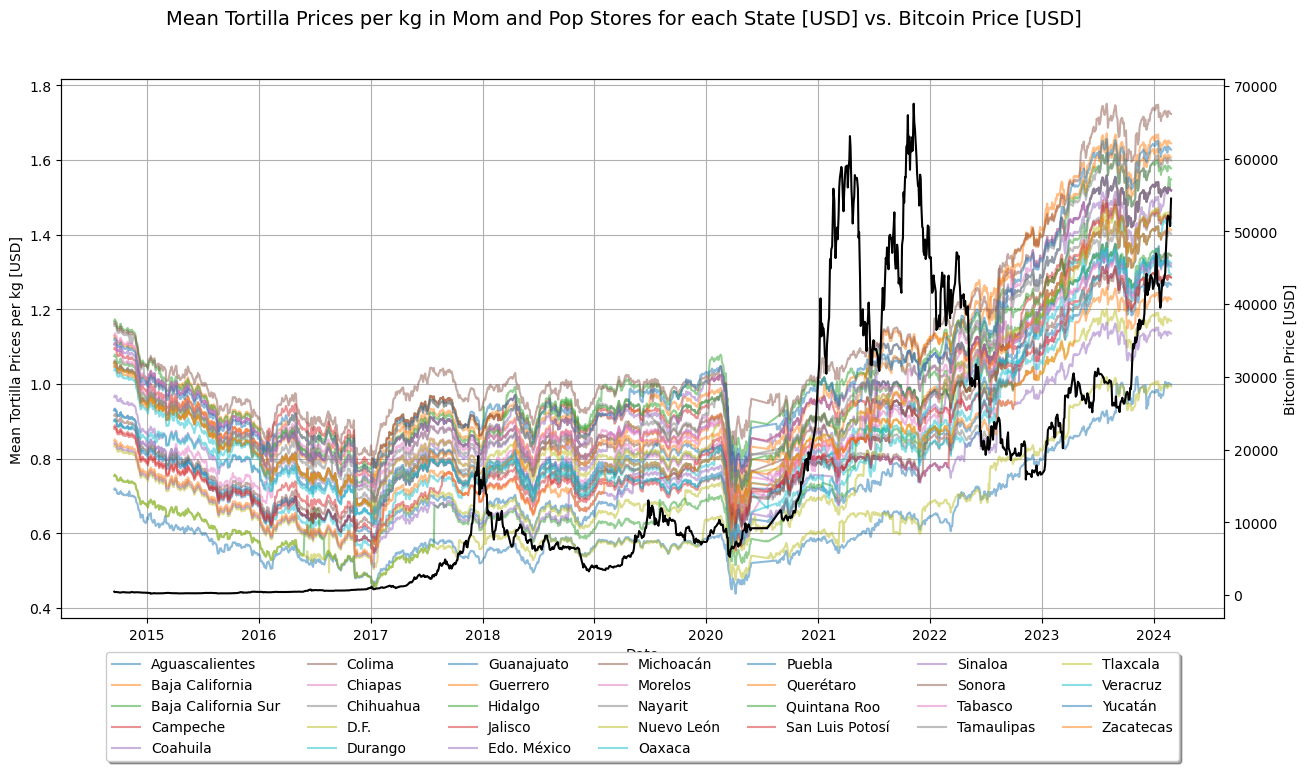

In [43]:
fig, axes = plt.subplots(figsize=(15, 7))
fig.suptitle("Mean Tortilla Prices per kg in Mom and Pop Stores for each State [USD] vs. Bitcoin Price [USD]", fontsize=14)

for state in df_merged["State"].unique():
    df_plot = df_merged[df_merged["State"]==state]
    axes.plot(df_plot[df_plot["Store type"]=="Mom and Pop Store"]["date"],
              df_plot[df_plot["Store type"]=="Mom and Pop Store"]["Tortilla Price per kg [USD]"], label=state, alpha=0.5)

ax2 = axes.twinx() 
ax2.plot(df_plot[df_plot["Store type"]=="Mom and Pop Store"]["date"],
         df_plot[df_plot["Store type"]=="Mom and Pop Store"]["Bitcoin Price [USD]"], label="Bitcoin Price", color = 'k')  

plt.ylabel('Bitcoin Price [USD]') 
axes.grid(True)
axes.set_ylabel('Mean Tortilla Prices per kg [USD]')
axes.set_xlabel('Date')
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=7)
plt.show()

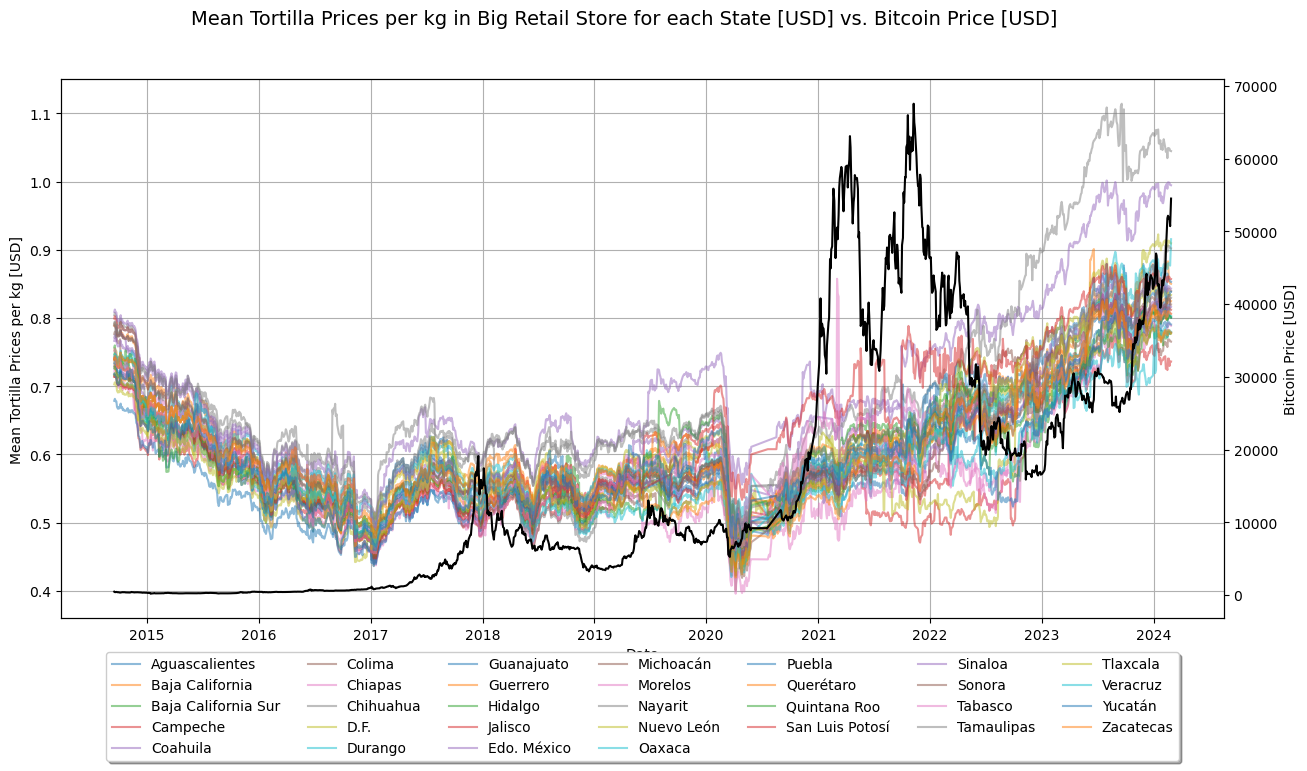

In [44]:
fig, axes = plt.subplots(figsize=(15, 7))
fig.suptitle("Mean Tortilla Prices per kg in Big Retail Store for each State [USD] vs. Bitcoin Price [USD]", fontsize=14)

for state in df_merged["State"].unique():
    df_plot = df_merged[df_merged["State"]==state]
    axes.plot(df_plot[df_plot["Store type"]=="Big Retail Store"]["date"],
              df_plot[df_plot["Store type"]=="Big Retail Store"]["Tortilla Price per kg [USD]"], label=state, alpha=0.5)
    
ax2 = axes.twinx() 
ax2.plot(df_plot[df_plot["Store type"]=="Big Retail Store"]["date"],
         df_plot[df_plot["Store type"]=="Big Retail Store"]["Bitcoin Price [USD]"], label="Bitcoin Price", color = 'k')  

plt.ylabel('Bitcoin Price [USD]') 
axes.grid(True)
axes.set_ylabel('Mean Tortilla Prices per kg [USD]')
axes.set_xlabel('Date')
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=7)
plt.show()

# 9. Calculate Spearman Correlations:

In [45]:
corr_values = {}
for store in df_merged["Store type"].unique():
    store_values = {}
    for state in df_merged["State"].unique():
        df_tmp = df_merged[df_merged["State"]==state]
        corr = df_tmp[df_tmp["Store type"]==store][["Bitcoin Price [USD]", "Tortilla Price per kg [USD]"]].corr(method='spearman').round(2)
        store_values.update({state: corr.values[1,0]})
    corr_values.update({store: store_values})
corr_values

{'Mom and Pop Store': {'Aguascalientes': 0.46,
  'Baja\xa0California': 0.57,
  'Baja\xa0California\xa0Sur': 0.72,
  'Campeche': 0.54,
  'Coahuila': 0.65,
  'Colima': 0.5,
  'Chiapas': 0.6,
  'Chihuahua': 0.29,
  'D.F.': 0.56,
  'Durango': 0.62,
  'Guanajuato': 0.71,
  'Guerrero': 0.55,
  'Hidalgo': 0.72,
  'Jalisco': 0.59,
  'Edo.\xa0México': 0.62,
  'Michoacán': 0.55,
  'Morelos': 0.42,
  'Nayarit': 0.4,
  'Nuevo\xa0León': 0.52,
  'Oaxaca': 0.54,
  'Puebla': 0.5,
  'Querétaro': 0.48,
  'Quintana\xa0Roo': 0.45,
  'San\xa0Luis\xa0Potosí': 0.68,
  'Sinaloa': 0.58,
  'Sonora': 0.62,
  'Tabasco': 0.31,
  'Tamaulipas': 0.59,
  'Tlaxcala': 0.48,
  'Veracruz': 0.29,
  'Yucatán': 0.65,
  'Zacatecas': 0.76},
 'Big Retail Store': {'Aguascalientes': 0.27,
  'Baja\xa0California': 0.35,
  'Baja\xa0California\xa0Sur': 0.33,
  'Campeche': 0.08,
  'Coahuila': 0.6,
  'Colima': 0.34,
  'Chiapas': 0.2,
  'Chihuahua': 0.45,
  'D.F.': 0.54,
  'Durango': 0.23,
  'Guanajuato': 0.56,
  'Guerrero': 0.36,
  'Hi

# 10. Plot and Save Results:

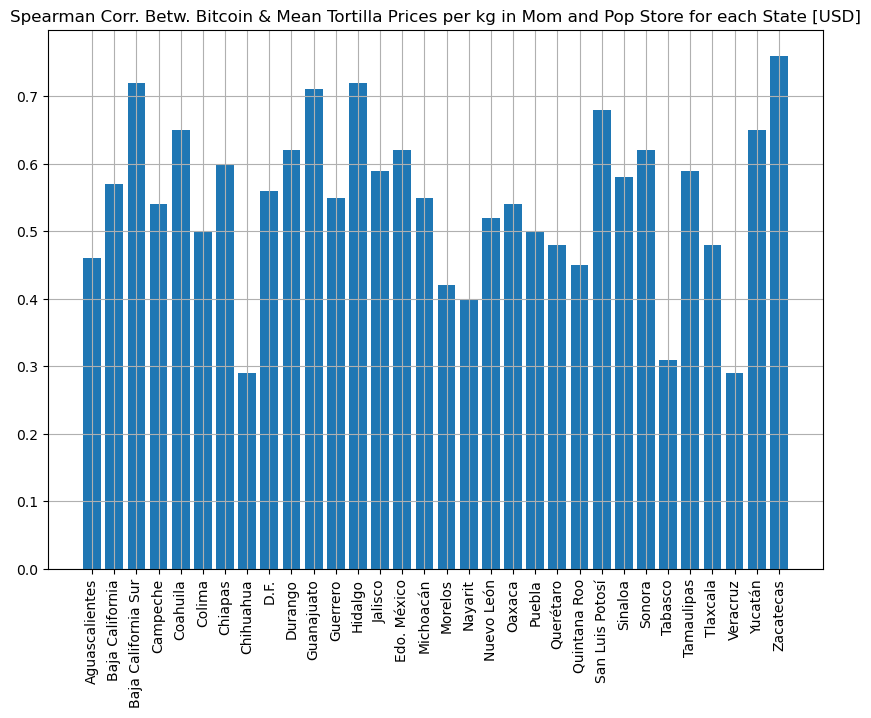

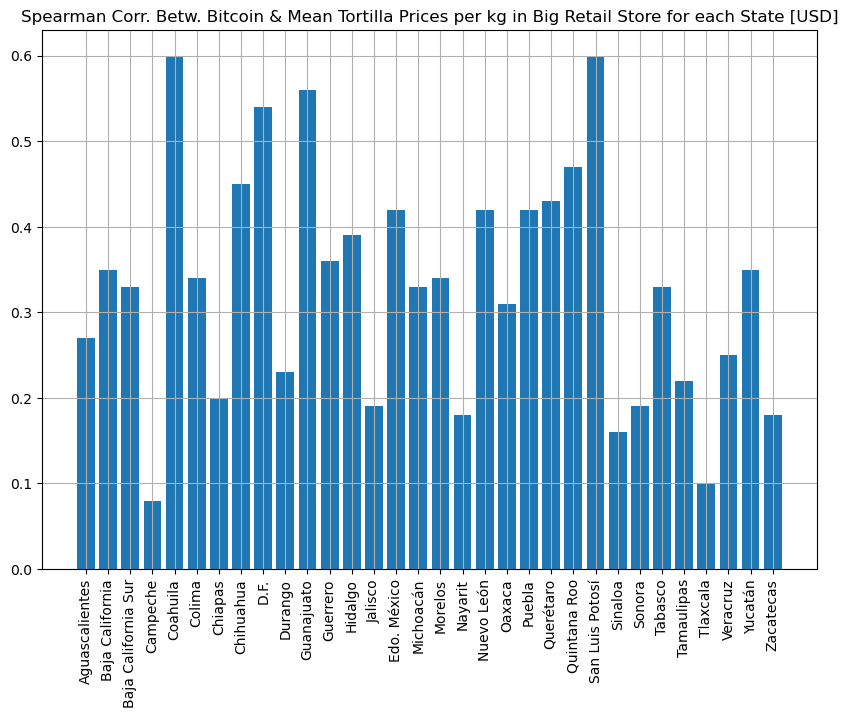

In [46]:
for store in corr_values.keys():
    store_values = corr_values[store]
    
    fig = plt.figure(figsize =(10, 7))
    plt.bar(store_values.keys(), store_values.values())
    plt.title("Spearman Corr. Betw. Bitcoin & Mean Tortilla Prices per kg in "+store+" for each State [USD]")
    plt.xticks(rotation=90)
    plt.grid(True)
    fig.savefig("result_plot_"+str(store).lower().replace(" ","_"), bbox_inches='tight')
    plt.show()

In [55]:
#js = json.dumps(corr_values)

# Open new json file if not exist it will create
#fp = open('results_spearman_corr.json', 'w')

# write to json file
#fp.write(js)

# close the connection
#fp.close()

df_corr_values = pd.DataFrame(data = corr_values["Mom and Pop Store"].keys(), columns=["State"])
df_corr_values["Spearman Corr"] = corr_values["Mom and Pop Store"].values()
df_corr_values["Store Type"] = ["Mom and Pop Store" for i in np.arange(0,df_corr_values.shape[0]) ]

tmp = pd.DataFrame(data = corr_values["Big Retail Store"].keys(), columns=["State"])
tmp["Spearman Corr"] = corr_values["Big Retail Store"].values()
tmp["Store Type"] = ["Big Retail Store" for i in np.arange(0,tmp.shape[0]) ]

df_corr_values = pd.concat([df_corr_values, tmp], ignore_index=True)
df_corr_values.to_csv('results_spearman_corr.csv', index=False)

# 11. Interpretation of the Results:

The correlation coefficient is simple and straightforward to interpret. The most commonly used interpretation guidelines are from Cohen (1988), which are the guidelines below and can be applied to the Pearson and the Spearman correlation coefficient:

Interpretation of the correlation coefficient according to Cohen (1988):
* |ρ| $\in$ [0.1, 0.3) $\rightarrow$ low/weak correlation 
* |ρ| $\in$ [0.3, 0.5) $\rightarrow$ medium/moderate correlation 
* |ρ| $\in$ [0.5, 1.0] $\rightarrow$ large/strong correlation

As we can see, there are many states with strong positive correlation between the Bitcoin price [USD] and the mean tortilla price per kilogram [USD] in mom-and-pop stores (up to 0.76) and four states with strong positive correlations in big retail stores (0.6, 0.54, 0.56 and 0.6).